   # Math 495 Final Project

 ## <span style="color: white;">Kordell Schrock & Clark Reimers</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
from word2number import w2n

df = pd.read_csv("GameSales2016.csv") #import dataset
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


 ## <span style="color: white;">Clean the Data</span>

In [22]:
#'User_Score' rows with 'tbd' values to be dropped
df = df.drop(df[df.User_Score == 'tbd'].index)
# Replace old videogame rating convention "K-A" with "E"
df['Rating']=df['Rating'].replace(['K-A'], 'E')
#Convert 'Year_of_Release' from float to integer
df['Year_of_Release']=df['Year_of_Release'].astype(int)
#Convert 'User_Score' from object to float
df['User_Score']=10*df['User_Score'].astype(float)

df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8000.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8300.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8000.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8500.0,431.0,Nintendo,E
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6600.0,129.0,Nintendo,E


In [20]:
df = df.dropna() #remove NA rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   int64  
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   float64
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(9), int64(1), object(6)
memory usage: 906.4+ KB


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
noObjects = df.select_dtypes(exclude=['object']) #remove objects
Xcols= noObjects.drop([], axis=1)
vif = pd.DataFrame()
vif["features"] = Xcols.columns
vif["vif_Factor"] = [variance_inflation_factor(Xcols.values, i) for i in range(Xcols.shape[1])]
print(vif) #vif Factor is helpful to find columns to remove since they are not good independent variables
#VIF factor under 10 is good for independent variables

          features     vif_Factor
0  Year_of_Release      33.849441
1         NA_Sales   31071.946995
2         EU_Sales   15037.048889
3         JP_Sales    2472.613112
4      Other_Sales    2271.673558
5     Global_Sales  126976.903063
6     Critic_Score      48.861177
7     Critic_Count       4.374225
8       User_Score      40.637793
9       User_Count       1.381430


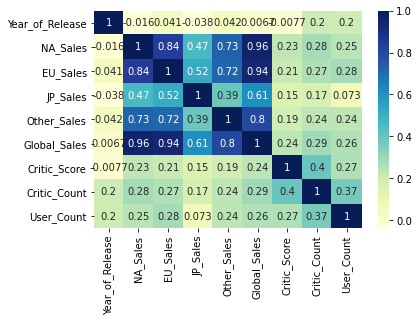

In [13]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu") #print the heat map
plt.show()